In [2]:
from import_all import *

In [3]:
file_path1 = '../emg+dataset+in+lower+limb/SEMG_DB1/A_TXT/10Amar.txt'

def load_and_process_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()
        content = '\n'.join(content.split('\n')[6:])  # Ignore les 6 premières lignes
    
    data = pd.read_csv(StringIO(content), sep='\t', header=None, names=['RF', 'BF', 'VM', 'ST', 'FX', 'Trash'], usecols=[0, 1, 2, 3, 4])
    
    data.dropna(inplace=True)
    data = data.astype(float)  # Convertir en float
    data['Time'] = data.index / 1000  # Ajout de la colonne temps
    return data

# Filtre passe-bande
def bandpass_filter(data, lowcut=20, highcut=450, fs=1000, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# Filtre notch
def notch_filter(data, notch_freq=50, fs=1000, quality_factor=30):
    nyquist = 0.5 * fs
    freq = notch_freq / nyquist
    b, a = iirnotch(freq, quality_factor)
    return filtfilt(b, a, data)

# Normalisation des données
def normalize_data(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

data = load_and_process_data(file_path1)

# Application des filtres et de la normalisation sur chaque signal
for col in ['RF', 'BF', 'VM', 'ST']:
    data[col] = bandpass_filter(data[col])
    data[col] = notch_filter(data[col])

data["FX"] = abs(data["FX"])  # Valeurs absolues pour FX

print(data.head())

         RF        BF        VM        ST    FX   Time
1  0.000103 -0.000773 -0.000194  0.000424  11.5  0.001
2 -0.006236 -0.005402 -0.004459  0.002595  10.3  0.002
3 -0.004448 -0.003465 -0.004263  0.001607  10.5  0.003
4 -0.003373 -0.004157 -0.003802 -0.000816  10.4  0.004
5  0.000049 -0.000679 -0.002176 -0.004109   9.9  0.005


In [4]:
# Détection améliorée des cycles de marche
signal = data['FX']
threshold = 0.5 * np.max(signal)  # Seuil ajusté dynamiquement

cycle_diffs = np.diff(np.where(signal > threshold)[0])
distance = int(np.mean(cycle_diffs)) if len(cycle_diffs) > 0 else 200  # Valeur par défaut

peaks, _ = find_peaks(signal, height=threshold, prominence=5, distance=distance)

# Vérification de la cohérence des cycles
if len(peaks) > 1:
    cycle_lengths = np.diff(peaks)
    mean_cycle_length = np.mean(cycle_lengths)
else:
    mean_cycle_length = 1000  # Valeur par défaut si un seul pic est trouvé

# Détection des débuts de cycles ajustés
shift_ratio = 0.7
adjusted_peaks = []
for i in range(len(peaks)):
    shift_amount = int(mean_cycle_length * shift_ratio)
    adjusted_start = peaks[i] - shift_amount
    adjusted_peaks.append(adjusted_start)

print(f'Nombre de débuts de cycles ajustés : {len(adjusted_peaks)}')
print(f'Débuts de cycles ajustés : {adjusted_peaks}')

# Verification du premier cycle
print(len(adjusted_peaks))
for i in range(len(adjusted_peaks)):
    if adjusted_peaks[0] < 0 :
        adjusted_peaks.pop(0)
        print(f'Premier cycle supprimé : {adjusted_peaks}')
    else:
        print(f'Premier cycle valide : {adjusted_peaks}')
        break

cycle_lengths = np.diff(adjusted_peaks)
mean_cycle_length = np.mean(cycle_lengths)

# Calcul du temps moyen des cycles **normaux** (excluant les cycles corrompus)
normal_cycle_times = [t for t in cycle_lengths if t > 1000]
mean_normal_cycle_time = np.mean(normal_cycle_times)



print(f'Temps pour chaque cycle : {cycle_lengths}')
print(f'Temps moyen des cycles normaux : {mean_normal_cycle_time:.2f}')

#Détection et correction des cycles anormaux
new_adjusted_peaks = []
for i in range(len(adjusted_peaks) - 1):
    start_time = data['Time'][adjusted_peaks[i]]
    end_time = data['Time'][adjusted_peaks[i + 1]]
    cycle_time = (end_time - start_time)*1000


    if cycle_time >= 1.50 * mean_normal_cycle_time:
        num_splits = round(cycle_time / mean_normal_cycle_time)  # Nombre de nouveaux cycles
        print(f'Cycle anormal détecté entre {start_time:.2f}s et {end_time:.2f}s, divisé en {num_splits} cycles.')

        # Ajout des nouveaux débuts de cycle répartis uniformément
        for j in range(num_splits):
            new_peak = adjusted_peaks[i] + int(j * mean_normal_cycle_time / (data['Time'].iloc[1]*1000 - data['Time'].iloc[0]*1000))
            new_adjusted_peaks.append(new_peak)
    elif cycle_time <= 0.50 * mean_normal_cycle_time:
        print(f'Cycle anormal détecté entre {start_time:.2f}s et {end_time:.2f}s, supprimé.')
    else:
        new_adjusted_peaks.append(adjusted_peaks[i])

# Ajout du dernier pic s'il n'a pas été traité
if adjusted_peaks:
    new_adjusted_peaks.append(adjusted_peaks[-1])

adjusted_peaks = new_adjusted_peaks

# Affichage des nouveaux débuts de cycles
print(f'Nouveaux débuts de cycles ajustés : {adjusted_peaks}')

# Début d'un nouveau cycle même si il n'y a pas de peak
if adjusted_peaks[-1]+int(np.mean(np.diff(adjusted_peaks))) < len(data):
    adjusted_peaks.append(adjusted_peaks[-1] + int(np.mean(np.diff(adjusted_peaks))))
    print(f'Ajout d\'un début de nouveau cycle : {adjusted_peaks}')
else:
    print(f'Aucun nouveau cycle ajouté : {adjusted_peaks}')

# Suppression des 3 premiers et 3 derniers cycles si le nombre total de cycles est supérieur à 20
if len(adjusted_peaks) > 20:
    adjusted_peaks = adjusted_peaks[3:-3]
    print(f'Suppression des 3 premiers et 3 derniers cycles : {adjusted_peaks}')

Nombre de débuts de cycles ajustés : 27
Débuts de cycles ajustés : [84, 1289, 2551, 3825, 3829, 5162, 5165, 5169, 5178, 6515, 7796, 9065, 9068, 9075, 10310, 11660, 12994, 14287, 14293, 15589, 16861, 18154, 19442, 20739, 20745, 20750, 22108]
27
Premier cycle valide : [84, 1289, 2551, 3825, 3829, 5162, 5165, 5169, 5178, 6515, 7796, 9065, 9068, 9075, 10310, 11660, 12994, 14287, 14293, 15589, 16861, 18154, 19442, 20739, 20745, 20750, 22108]
Temps pour chaque cycle : [1205 1262 1274    4 1333    3    4    9 1337 1281 1269    3    7 1235
 1350 1334 1293    6 1296 1272 1293 1288 1297    6    5 1358]
Temps moyen des cycles normaux : 1292.76
Cycle anormal détecté entre 3.83s et 3.83s, supprimé.
Cycle anormal détecté entre 5.16s et 5.17s, supprimé.
Cycle anormal détecté entre 5.17s et 5.17s, supprimé.
Cycle anormal détecté entre 5.17s et 5.18s, supprimé.
Cycle anormal détecté entre 9.06s et 9.07s, supprimé.
Cycle anormal détecté entre 9.07s et 9.07s, supprimé.
Cycle anormal détecté entre 14.29s 

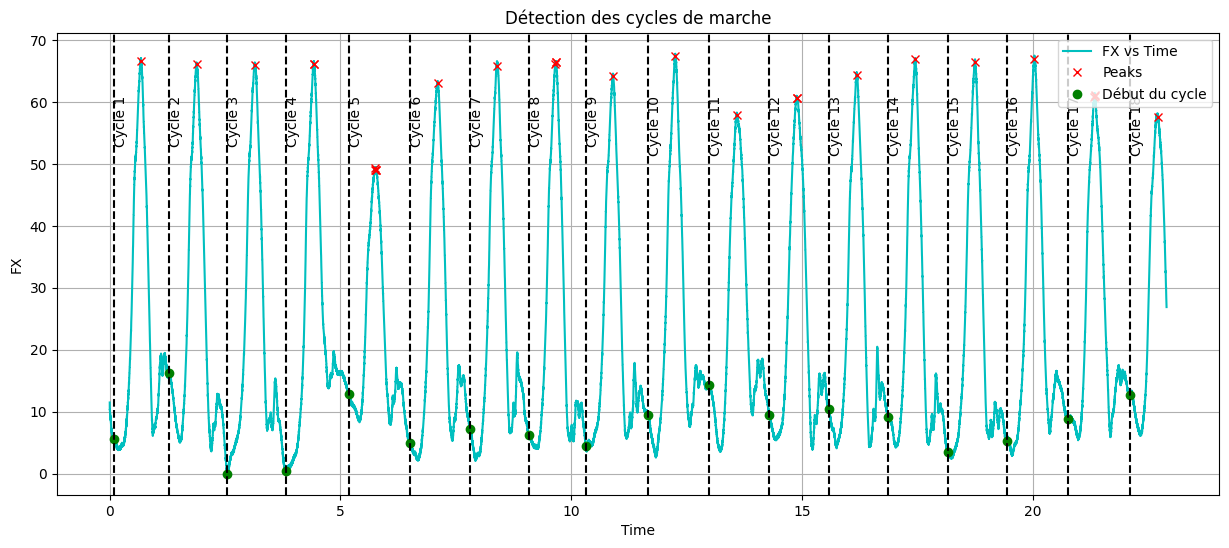

In [5]:
# Affichage du signal FX avec les cycles marqués
plt.figure(figsize=(15, 6))
plt.plot(data['Time'], data['FX'], label='FX vs Time', color='c')
plt.plot(data['Time'][peaks], data['FX'][peaks], 'rx', label='Peaks')
plt.plot(data['Time'][adjusted_peaks], data['FX'][adjusted_peaks], 'go', label='Début du cycle')

for i, start in enumerate(adjusted_peaks):
    plt.axvline(x=data['Time'][start], color='k', linestyle='--')
    plt.text(data['Time'][start], max(data['FX']) * 0.9, f'Cycle {i+1}', rotation=90, verticalalignment='top')

plt.xlabel('Time')
plt.ylabel('FX')
plt.title('Détection des cycles de marche')
plt.legend()
plt.grid(True)
plt.show()


In [6]:
# On calcul le temps de chaque cycle et on divise par la fréquence d'échantillonnage pour obtenir le temps en secondes
cycle_durations = np.diff(adjusted_peaks) / 1000 

# Calcul du temps de cycle moyen
average_cycle_time = np.mean(cycle_durations)

print(f"Durée de chaque cycles (en secondes): {cycle_durations}")
print(f"Temps moyen de cycle (en secondes): {average_cycle_time}")

Durée de chaque cycles (en secondes): [1.205 1.262 1.278 1.349 1.337 1.281 1.279 1.235 1.35  1.334 1.299 1.296
 1.272 1.293 1.288 1.308 1.358]
Temps moyen de cycle (en secondes): 1.2955294117647058


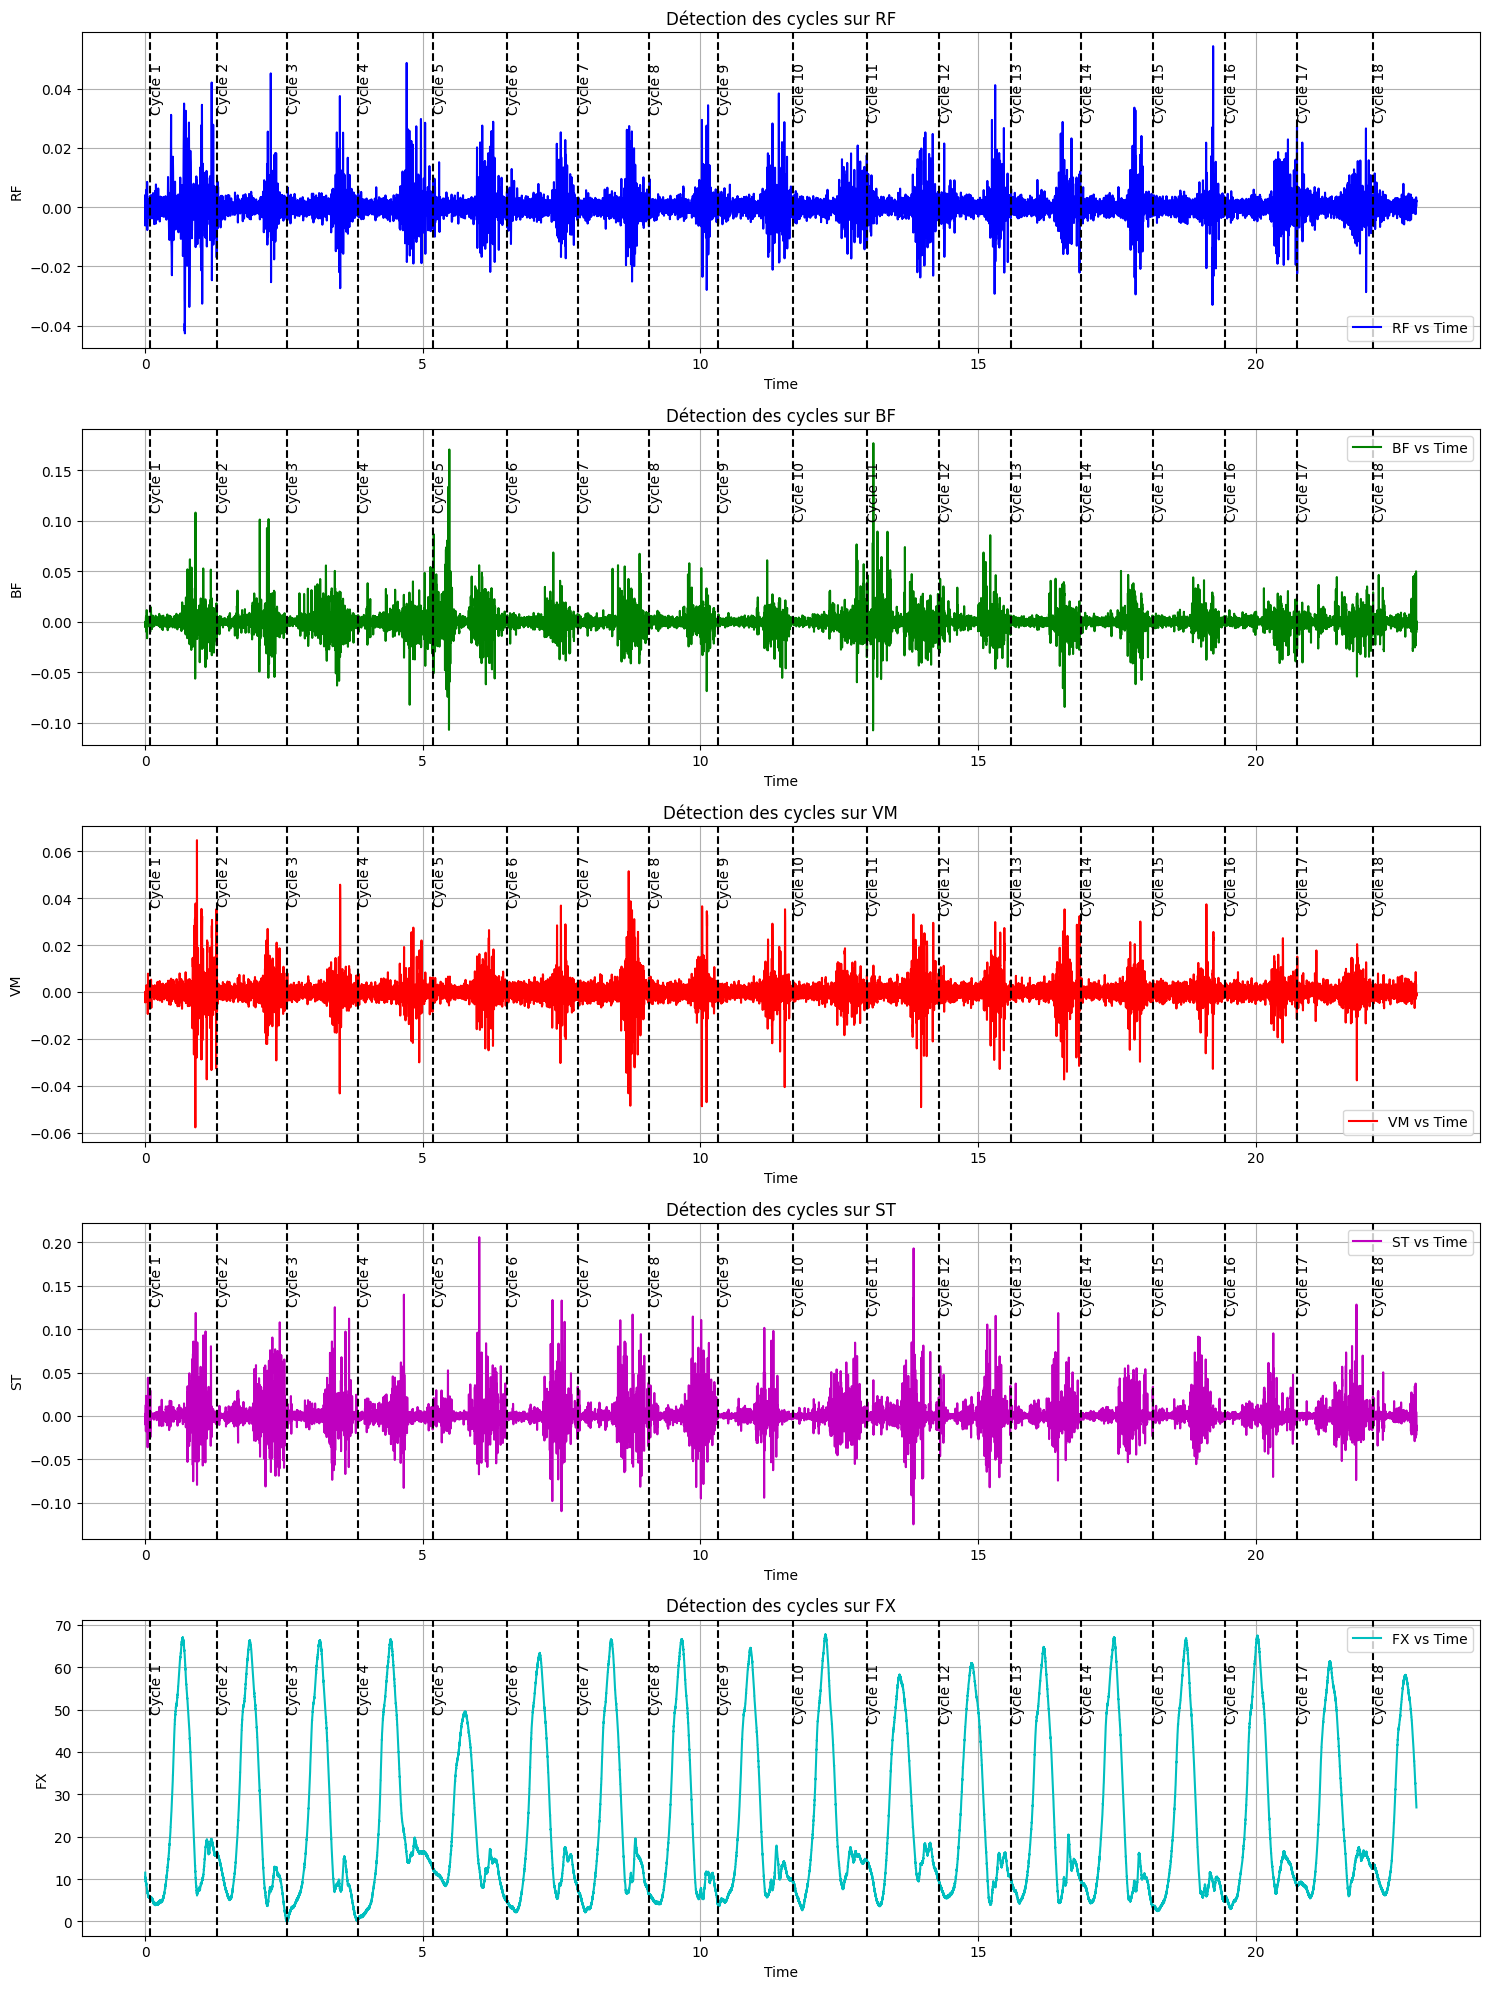

In [7]:
# Liste des colonnes à afficher
columns = ['RF', 'BF', 'VM', 'ST', 'FX']
colors = ['b', 'g', 'r', 'm', 'c']

# Création des graphiques pour chaque signal avec les cycles marqués
fig, axs = plt.subplots(len(columns), figsize=(15, 20))
for i, col in enumerate(columns):
    axs[i].plot(data['Time'], data[col], label=f'{col} vs Time', color=colors[i])
    for j, start in enumerate(adjusted_peaks):
        axs[i].axvline(x=data['Time'][start], color='k', linestyle='--')
        axs[i].text(data['Time'][start], max(data[col]) * 0.9, f'Cycle {j+1}', rotation=90, verticalalignment='top')
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel(col)
    axs[i].set_title(f'Détection des cycles sur {col}')
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()

In [8]:
# Convert float values in adjusted_peaks to integers
adjusted_peaks = [int(peak) for peak in adjusted_peaks]

# RMS (Root Mean Square) pour chaque cycle
rms_values_RF = []
rms_values_BF = []
rms_values_VM = []
rms_values_ST = []
for i in range(len(adjusted_peaks) - 1):
    start = adjusted_peaks[i]
    end = adjusted_peaks[i + 1]
    rms_RF = np.sqrt(np.mean(data['RF'][start:end] ** 2))
    rms_values_RF.append(rms_RF)
    rms_BF = np.sqrt(np.mean(data['BF'][start:end] ** 2))
    rms_values_BF.append(rms_BF)
    rms_VM = np.sqrt(np.mean(data['VM'][start:end] ** 2))
    rms_values_VM.append(rms_VM)
    rms_ST = np.sqrt(np.mean(data['ST'][start:end] ** 2))
    rms_values_ST.append(rms_ST)


print(rms_values_RF)
print(rms_values_BF)
print(rms_values_VM)
print(rms_values_ST)

mean_rms_RF = np.mean(rms_values_RF)
mean_rms_BF = np.mean(rms_values_BF)
mean_rms_VM = np.mean(rms_values_VM)
mean_rms_ST = np.mean(rms_values_ST)

print(f'Mean RMS RF: {mean_rms_RF:.4f}')
print(f'Mean RMS BF: {mean_rms_BF:.4f}')
print(f'Mean RMS VM: {mean_rms_VM:.4f}')
print(f'Mean RMS ST: {mean_rms_ST:.4f}')

[0.009089005198125475, 0.003990071589854721, 0.003984424458686678, 0.004762288475085458, 0.004507975119316081, 0.003945513749148086, 0.004379804865370081, 0.00406730647836314, 0.00439028732386056, 0.003400641341371017, 0.004782434983255079, 0.004565582999059847, 0.004005140900705594, 0.004481899576095302, 0.004436161635406078, 0.004436107011459227, 0.0039729238566578295]
[0.010493100847334225, 0.011189575399334347, 0.011732309167763445, 0.009522403760414622, 0.018248642200984436, 0.007685661226720042, 0.009607804633089337, 0.007913124434391789, 0.007066409634054949, 0.008043806727971264, 0.0166084638373125, 0.009807212547893405, 0.009174273876813984, 0.008648154012211931, 0.006538646467330456, 0.007157195682798119, 0.008014559218064397]
[0.008569202978927673, 0.004687401971161625, 0.005098038561339523, 0.004347260313225822, 0.004421469116248407, 0.00469697589305868, 0.0072703605197575885, 0.005359534146034666, 0.0046661935840651945, 0.00371442628919386, 0.0062529919279357025, 0.0049033

In [9]:
#Energie pour chaque cycle

energie_values_RF = []
energie_values_BF = []
energie_values_VM = []
energie_values_ST = []

for i in range(len(adjusted_peaks) - 1):
    start = adjusted_peaks[i]
    end = adjusted_peaks[i + 1]
    energie_RF = np.sum(np.square(data['RF'][start:end]))
    energie_values_RF.append(energie_RF)
    energie_BF = np.sum(np.square(data['BF'][start:end]))
    energie_values_BF.append(energie_BF)
    energie_VM = np.sum(np.square(data['VM'][start:end]))
    energie_values_VM.append(energie_VM)
    energie_ST = np.sum(np.square(data['ST'][start:end]))
    energie_values_ST.append(energie_ST)

print(energie_values_RF)
print(energie_values_BF)
print(energie_values_VM)
print(energie_values_ST)

mean_energie_RF = np.mean(energie_values_RF)
mean_energie_BF = np.mean(energie_values_BF)
mean_energie_VM = np.mean(energie_values_VM)
mean_energie_ST = np.mean(energie_values_ST)

print(f'Mean Energie RF: {mean_energie_RF:.4f}')
print(f'Mean Energie BF: {mean_energie_BF:.4f}')
print(f'Mean Energie VM: {mean_energie_VM:.4f}')
print(f'Mean Energie ST: {mean_energie_ST:.4f}')


[0.09954506866732003, 0.020091887170713217, 0.020289065705201247, 0.030594499160387967, 0.027170299647310485, 0.01994142787198195, 0.024534661352502162, 0.020430582756334435, 0.02602074076116847, 0.01542685828454399, 0.029710317995411555, 0.02701453436521039, 0.02040434742309013, 0.025973038986592797, 0.025347234711417962, 0.02574019140558996, 0.021434840352347655]
[0.1326767242977531, 0.15801072619314416, 0.17591296620540636, 0.12232215788470766, 0.4452383036940585, 0.07566788665813391, 0.11806437472067693, 0.07733265981799792, 0.06741109590695721, 0.08631357078705901, 0.3583175512748768, 0.12465111767558698, 0.10706080708415878, 0.09670420418988597, 0.055067020140656175, 0.06700288865475815, 0.08722863054649124]
[0.08848464383134581, 0.02772833239593336, 0.03321521638697227, 0.025494308839549222, 0.026137533288119727, 0.028260887233707187, 0.06760556372959253, 0.035474888734201744, 0.029394039461361102, 0.018405148185577862, 0.050790780558026945, 0.03115899118522042, 0.04726567783318